### Homework D - Time Series Prediction using Reservoir Computing ###

Author: Jesper Olsson

***

In [29]:
# Import packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

## Problem 1) 

Create dataset by solving the Lorenz system

In [30]:
from scipy.integrate import solve_ivp   # Solve initial value problems

# Parameters
sigma = 10
r = 28
b = 8/3

dt = 0.02
t_max = 50
num_steps = int(t_max/dt)
print("Number of time steps", num_steps)

# Initial conditions
initial_conditions = [0.3, 0.7, 0.95]

def lorenz(t, state, sigma, b, r):
    x, y, z = state
    x_dot = -sigma*(x - y)
    y_dot = r*x - y - x*z
    z_dot = -b*z + x*y
    return x_dot, y_dot, z_dot

# Integrate the Lorenz equations.
sol_fun = solve_ivp(lorenz, (0, t_max), initial_conditions, args=(sigma, b, r),
                 dense_output=True)
# Interpolate solution onto the time grid, t.
t_eval = np.linspace(0, t_max, num_steps)
x, y, z = sol_fun.sol(t_eval)

data_sol = np.array([x, y, z])

Number of time steps 2500


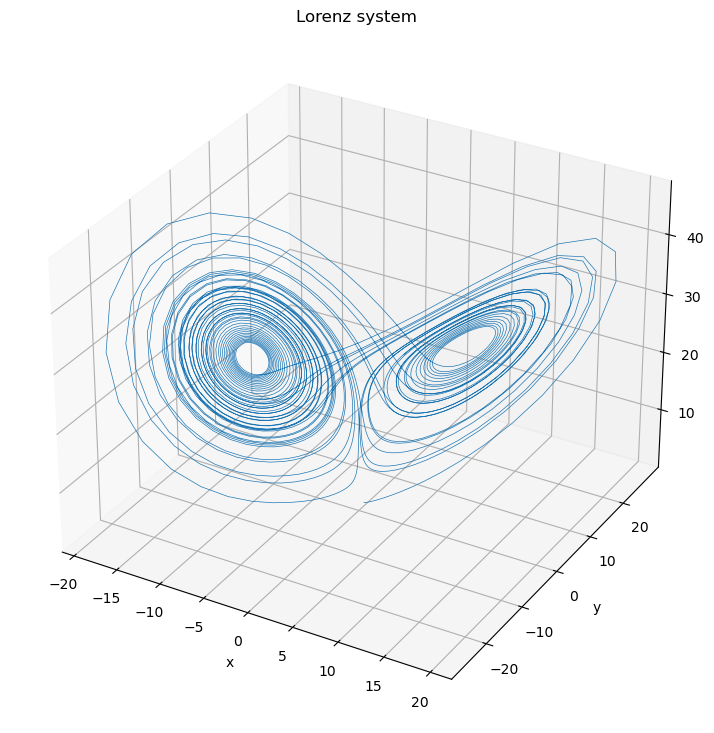

In [31]:
# Plot the solution
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(9, 9))

ax = fig.add_subplot(projection='3d') # 3D plot
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Lorenz system')
ax.plot(x, y, z, lw=0.5)
plt.show()

Divide data into train and test data

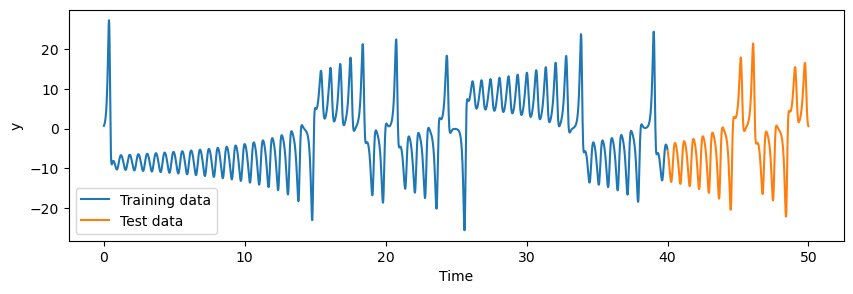

In [32]:
train_share = 0.8 

train_data = data_sol[:, :int(train_share*num_steps)] # Training data
test_data = data_sol[:, int(train_share*num_steps):] # Test data

train_time = t_eval[:int(train_share*num_steps)] # Training time
test_time = t_eval[int(train_share*num_steps):] # Test time

# Plot the data
fig = plt.figure(figsize=(10, 3))
plt.plot(train_time, train_data[1, :], label='Training data')
plt.plot(test_time, test_data[1, :], label='Test data')
plt.xlabel('Time')
plt.ylabel('y')
plt.legend()
plt.show()

## Problem 2)

Set up a single-layer reservoir and minimize energy function

In [33]:
# Define the network
N_in = 3 # Number of input neurons
N_out = 3 # Number of output neurons
N_res = 500 # Number of reservoir neurons

np.random.seed(42)
W_in = np.random.normal(0, np.sqrt(0.002), (N_res, N_in))
W_res = np.random.normal(0, np.sqrt(2/N_res), (N_res, N_res))

# Train the network

num_steps_train = train_data.shape[1] # Number of training steps
R = np.zeros((N_res, num_steps_train)) # Reservoir states, initialized to 0

for t in range(num_steps_train-1):
    X = train_data[:,t]
    r = R[:,t]
    
    R[:,t+1] = np.tanh(W_res @ r + W_in @ X)
    
I = np.eye(N_res) # Identity matrix
k=0.01   # Ridge regression parameter

M1 = train_data @ R.T
M2 = R @ R.T + k*I
W_out = M1 @ np.linalg.inv(M2)

O_train = W_out @ R # Output of the network

print("W_out shape:", W_out.shape)
print("W_out:")
print(W_out)

W_out shape: (3, 500)
W_out:
[[-0.07500692  0.41660278  0.23401525 ...  0.07656106  0.00526763
   0.08379243]
 [ 0.16504497 -0.31024741  0.03436061 ...  0.22150912  0.13600613
   0.25820938]
 [ 0.34009812 -0.13336974 -0.12709106 ... -0.13842779 -0.23487941
   0.19355101]]


Predict the test data

In [34]:
# Predict the values in test data
O_test = np.zeros((N_out, test_data.shape[1])) # Output states, initialized to 0

# Get the last state from training data
r = R[:, -1]
for t in range(test_data.shape[1]-1):
    O = W_out @ r # first state comes from training
    
    r = np.tanh(W_res @ r + W_in @ O)
    O_test[:,t] = O

(3, 2000) (3, 500)


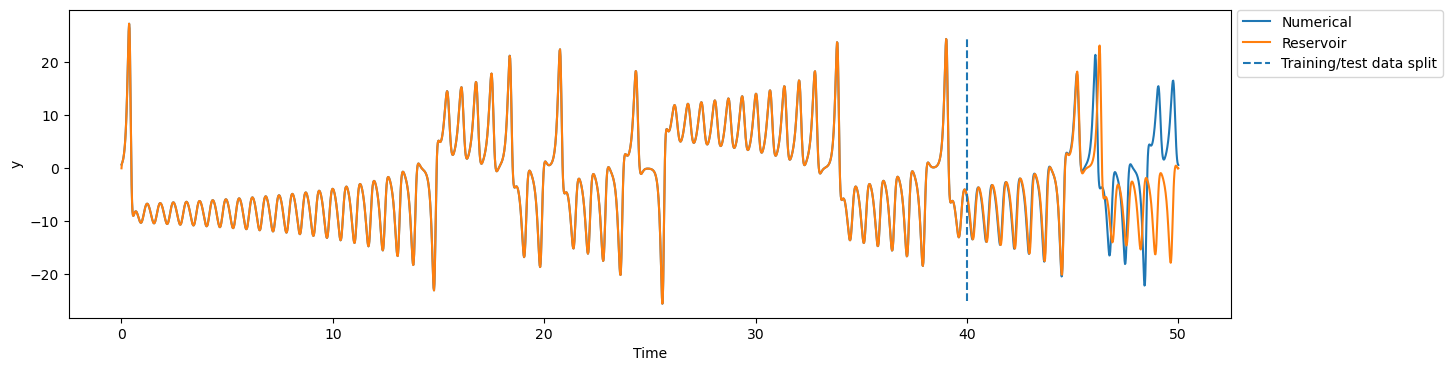

In [35]:
# Plot the results
fig = plt.figure(figsize=(15, 4))
print(O_train.shape, O_test.shape)
plt.plot(t_eval, data_sol[1], label='Numerical')
plt.plot(t_eval, np.hstack((O_train[1], O_test[1])), label='Reservoir')
plt.vlines(t_eval[int(train_share*num_steps)], -25, 25, linestyles='dashed', label='Training/test data split')
plt.xlabel('Time')
plt.ylabel('y')
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0.)
plt.show()

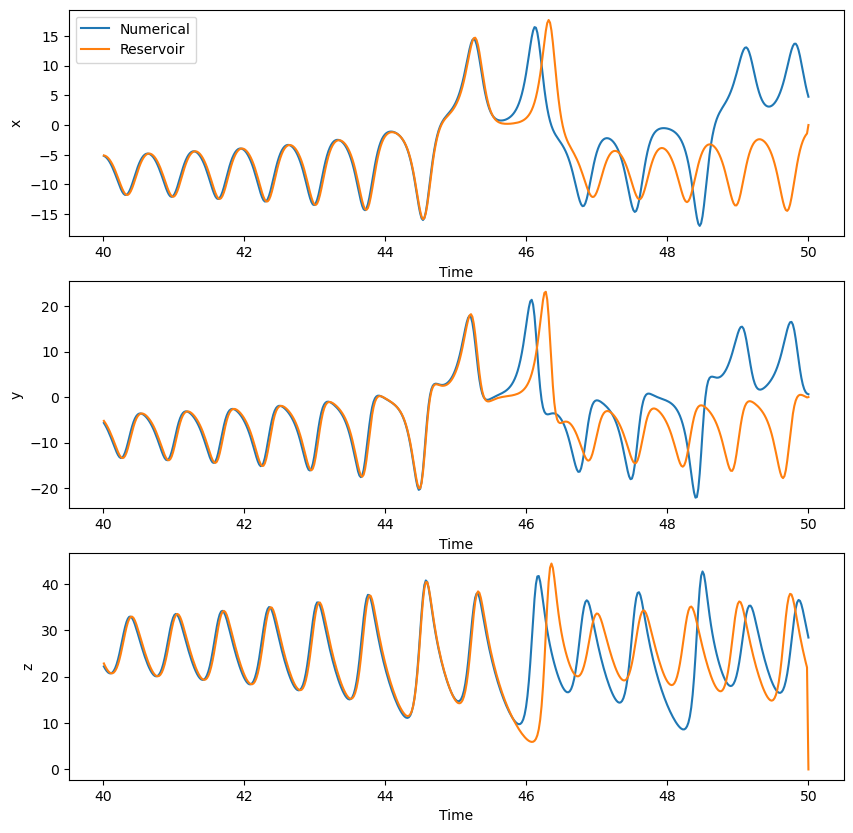

In [36]:
# plot only the test data
fig = plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(test_time, test_data[0], label='Numerical')
plt.plot(test_time, O_test[0], label='Reservoir')
plt.xlabel('Time')
plt.ylabel('x')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(test_time, test_data[1], label='Numerical')
plt.plot(test_time, O_test[1], label='Reservoir')
plt.xlabel('Time')
plt.ylabel('y')

plt.subplot(3, 1, 3)
plt.plot(test_time, test_data[2], label='Numerical')
plt.plot(test_time, O_test[2], label='Reservoir')
plt.xlabel('Time')
plt.ylabel('z')

plt.show()

In [37]:
# Define the loss function
def loss_fun(data, O): # loss function defined as the root mean squared error
    squared_error = 0
    for i in range(0,np.shape(data)[1]):  # sum over all time points
        squared_error += sum((data[:,i] - O[:,i])**2) # sum over all variables
    return np.sqrt(squared_error)

def loss_fun_time(time_span, data, O): # loss function defined as time until error is too large
    time_var = 0 
    time_step = (max(time_span) - min(time_span)) / len(time_span) # time elapsed between each time step
    for i in range(0, len(time_span)): 
        Error = sum(abs(data[:,i] - O[:,i])) # error defined as distance between predicted and actual value
        if Error > 3.5:
            break
        else: 
            time_var += time_step
    return(time_var)

Print out the final weights

In [38]:
test_loss = loss_fun(test_data, O_test)
print("Test loss: ", test_loss)
test_loss_time = loss_fun_time(test_time, test_data, O_test)
print("Test loss (time):", test_loss_time)

print("Weights:")
print(W_out)

Test loss:  282.40875260107816
Test loss (time): 2.1765106042416953
Weights:
[[-0.07500692  0.41660278  0.23401525 ...  0.07656106  0.00526763
   0.08379243]
 [ 0.16504497 -0.31024741  0.03436061 ...  0.22150912  0.13600613
   0.25820938]
 [ 0.34009812 -0.13336974 -0.12709106 ... -0.13842779 -0.23487941
   0.19355101]]


## Problem 3) 

### Full reservoir

In [39]:
def full_reservoir(w_res_var):
    
    # Define the network
    N_in = 3 # Number of input neurons
    N_out = 3 # Number of output neurons
    N_res = 500 # Number of reservoir neurons

    np.random.seed(42) 
    W_in = np.random.normal(0, np.sqrt(0.002), (N_res, N_in))
    W_res = np.random.normal(0, np.sqrt(w_res_var), (N_res, N_res))

    # calculate maximum singular value
    max_sing_val = np.max(np.abs(np.linalg.eigvals(W_res)))
    
    num_steps_train = train_data.shape[1] # Number of training steps
    R = np.zeros((N_res, num_steps_train)) # Reservoir states, initialized to 0

    for t in range(num_steps_train-1):
        X = train_data[:,t]
        r = R[:,t]
        
        R[:,t+1] = np.tanh(W_res @ r + W_in @ X)
        
    I = np.eye(N_res) # Identity matrix
    k=0.01   # Ridge regression parameter

    M1 = train_data @ R.T
    M2 = R @ R.T + k*I
    W_out = M1 @ np.linalg.inv(M2)
    
    # Predict the values in test data
    O_test = np.zeros((N_out, test_data.shape[1])) # Output states, initialized to 0

    # Get the last state from training data
    r = R[:, -1]
    for t in range(test_data.shape[1]-1):
        O = W_out @ r # first state comes from training
        
        r = np.tanh(W_res @ r + W_in @ O)
        O_test[:,t] = O
    
    test_loss = loss_fun(test_data, O_test)
    test_loss_time = loss_fun_time(test_time, test_data, O_test)
    
    test_losses = [test_loss, test_loss_time]
    
    return test_losses, max_sing_val
    

Vary the variance of the reservoir weight matrix to vary the maximal singular value

In [40]:
w_res_var = np.arange(0.00001, 0.4, 0.001)
print("Number of values ", len(w_res_var))
test_losses = np.zeros((2,len(w_res_var)))
max_sing_val = np.zeros(len(w_res_var))

for i in range(len(w_res_var)):
    test_losses[:,i], max_sing_val[i]  = full_reservoir(w_res_var[i])


Number of values  400


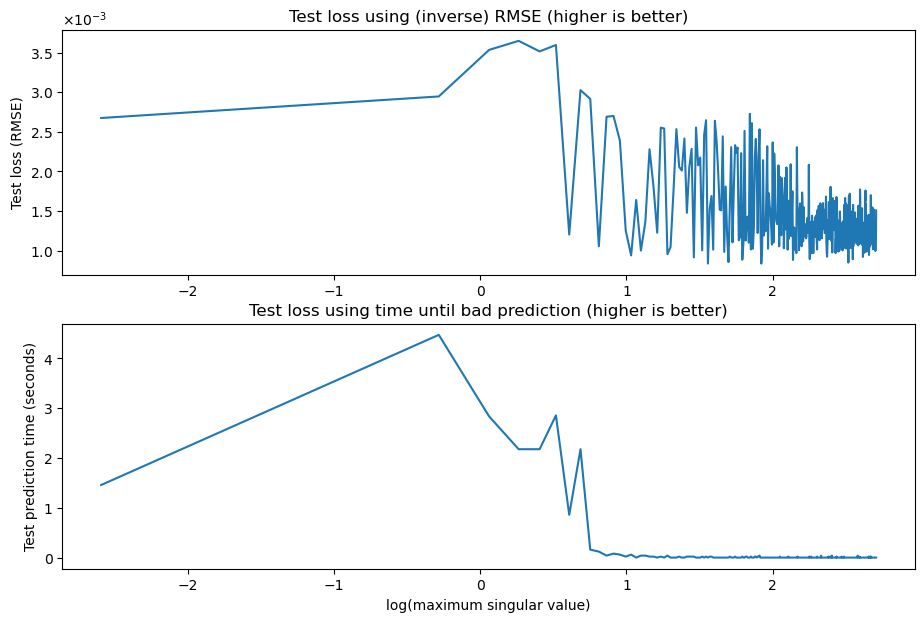

In [41]:
# Plot the results
fig = plt.figure(figsize=(11, 7))
plt.subplot(2,1,1)
plt.plot(np.log(max_sing_val), 1/test_losses[0])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
plt.ylabel('Test loss (RMSE)')
plt.title("Test loss using (inverse) RMSE (higher is better)")

plt.subplot(2,1,2)
plt.plot(np.log(max_sing_val), test_losses[1])
plt.xlabel('log(maximum singular value)')
plt.ylabel('Test prediction time (seconds)')
plt.title("Test loss using time until bad prediction (higher is better)")

plt.show()

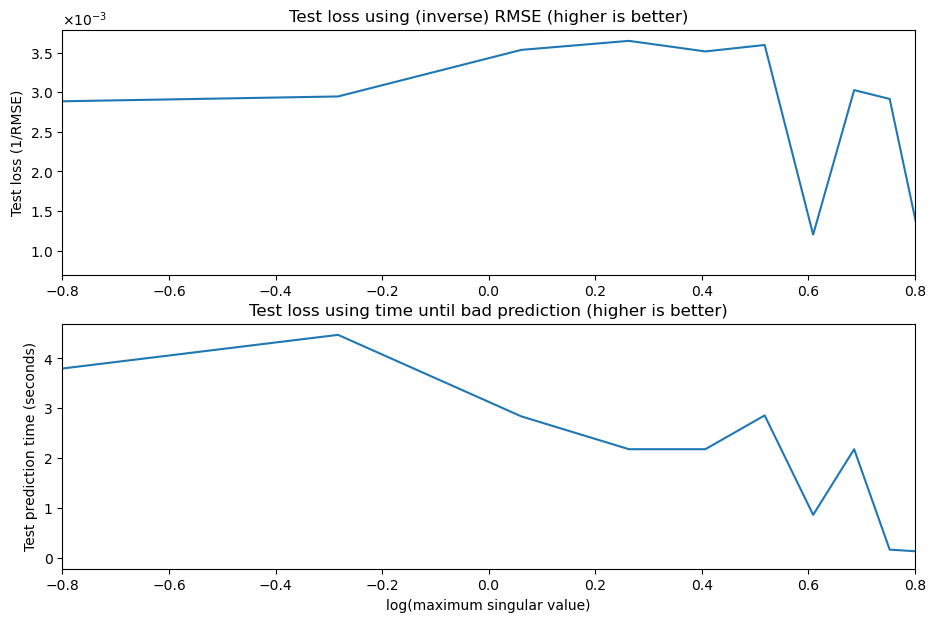

In [42]:
# Show where the best results are
fig = plt.figure(figsize=(11, 7))
plt.subplot(2,1,1)
plt.plot(np.log(max_sing_val), 1/test_losses[0])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
plt.ylabel('Test loss (1/RMSE)')
plt.xlim(-0.8, 0.8)

plt.title("Test loss using (inverse) RMSE (higher is better)")

plt.subplot(2,1,2)
plt.plot(np.log(max_sing_val), test_losses[1])
plt.xlabel('log(maximum singular value)')
plt.ylabel('Test prediction time (seconds)')
plt.xlim(-0.8, 0.8)
plt.title("Test loss using time until bad prediction (higher is better)")

plt.show()

Define network to predict just y

In [43]:
def loss_fun_y(y, O): # loss function defined as the root mean squared error
    squared_error = 0
    for i in range(0, len(y)):  # sum over all time points
        squared_error += (y[i] - O[i])**2
    return np.sqrt(squared_error)

def loss_fun_time_y(time_span, y, O): # loss function defined as time until error is too large
    time_var = 0 
    time_step = (max(time_span) - min(time_span)) / len(time_span) # time elapsed between each time step
    for i in range(0, len(time_span)): 
        Error = abs(y[i] - O[i])         # error defined as distance between predicted and actual value
        if Error > 3.5/2:           # smaller, since we compare only one variable
            break
        else: 
            time_var += time_step
    return(time_var)

def reservoir_y(w_res_var):
    # Define the network
    N_in = 1 # Number of input neurons
    N_out = 1 # Number of output neurons
    N_res = 500 # Number of reservoir neurons

    np.random.seed(42) 
    W_in = np.random.normal(0, np.sqrt(0.002), (N_res, N_in))
    W_in = np.squeeze(W_in) # Remove unnecessary dimension
    W_res = np.random.normal(0, np.sqrt(w_res_var), (N_res, N_res))

    # calculate maximum singular value
    max_sing_val = np.max(np.abs(np.linalg.eigvals(W_res)))
    
    num_steps_train = train_data.shape[1] # Number of training steps
    R = np.zeros((N_res, num_steps_train)) # Reservoir states, initialized to 0

    for t in range(num_steps_train-1):
        X = train_data[1,t] # Use only y as input
        r = R[:,t]
        
        R[:,t+1] = np.tanh(W_res @ r + W_in * X) # we want shape 
        
    I = np.eye(N_res) # Identity matrix
    k=0.01   # Ridge regression parameter

    M1 = train_data[1,:] @ R.T
    M2 = R @ R.T + k*I
    W_out = M1 @ np.linalg.inv(M2)
    
    # Predict the values in test data
    O_test = np.zeros((N_out, test_data.shape[1])) # Output states, initialized to 0
    O_test = np.squeeze(O_test) # Remove unnecessary dimension

    # Get the last state from training data
    r = R[:, -1]
    for t in range(test_data.shape[1]-1):
        O = W_out @ r # first state comes from training
        
        r = np.tanh(W_res @ r + W_in * O)
        O_test[t] = O
    
    test_loss = loss_fun_y(test_data[1,:], O_test)
    test_loss_time = loss_fun_time_y(test_time, test_data[1,:], O_test)
    
    test_losses = [test_loss, test_loss_time]
    
    return test_losses, max_sing_val

In [44]:
w_res_var_y = np.arange(0.00001, 0.4, 0.001)
print("Number of values:", len(w_res_var_y))
test_losses_y = np.zeros((2,len(w_res_var_y)))
max_sing_val_y = np.zeros(len(w_res_var_y))

for i in range(len(w_res_var_y)):
    test_losses_y[:,i], max_sing_val_y[i]  = reservoir_y(w_res_var_y[i])

Number of values: 400


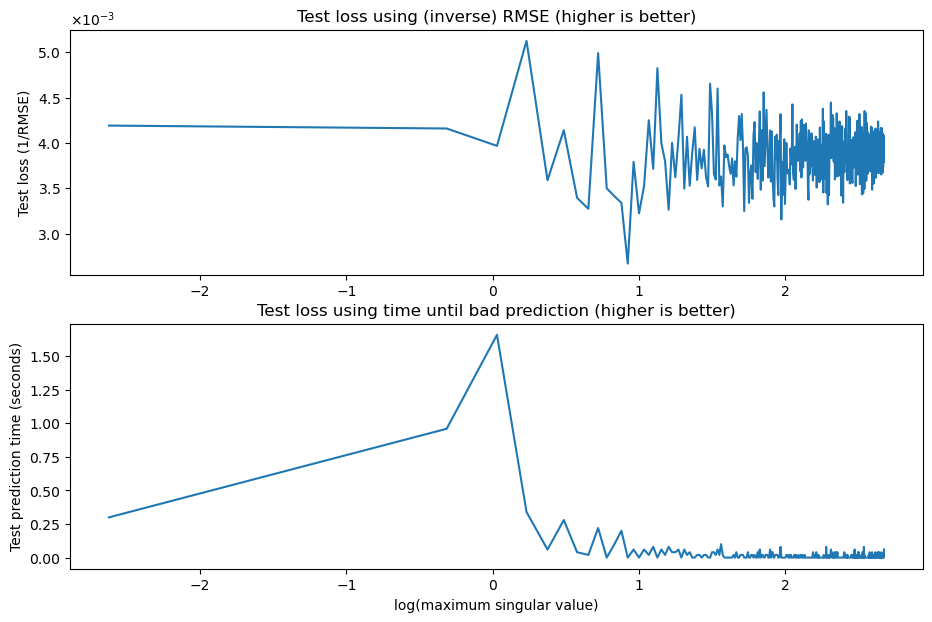

In [45]:
# Plot the results
fig = plt.figure(figsize=(11, 7))
plt.subplot(2,1,1)
plt.plot(np.log(max_sing_val_y), 1/test_losses_y[0])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
plt.ylabel('Test loss (1/RMSE)')
plt.title("Test loss using (inverse) RMSE (higher is better)")

plt.subplot(2,1,2)
plt.plot(np.log(max_sing_val_y), test_losses_y[1])
plt.xlabel('log(maximum singular value)')
plt.ylabel('Test prediction time (seconds)')
plt.title("Test loss using time until bad prediction (higher is better)")

plt.show()

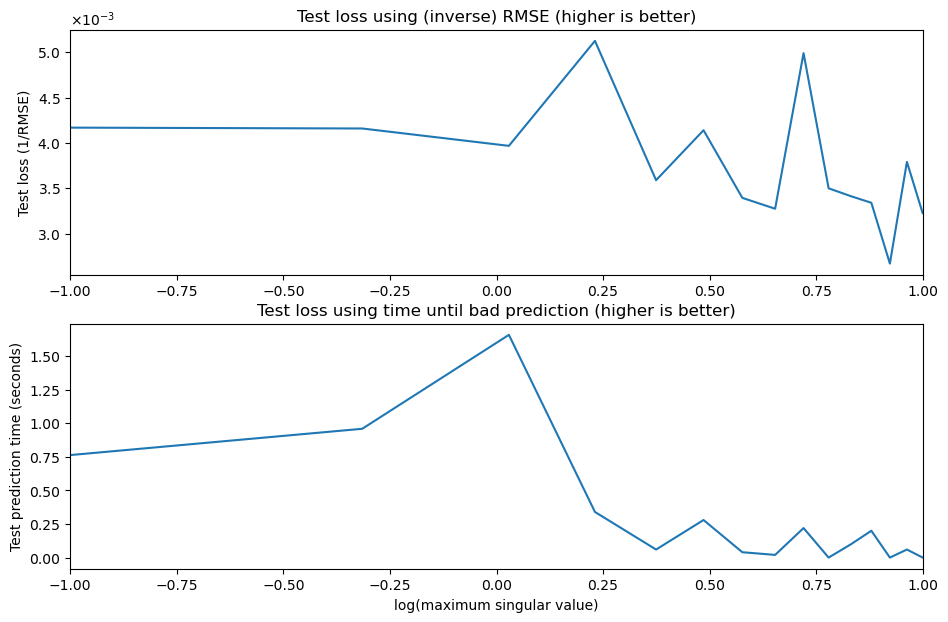

In [46]:
# Show where the best results are
fig = plt.figure(figsize=(11, 7))
plt.subplot(2,1,1)
plt.plot(np.log(max_sing_val_y), 1/test_losses_y[0])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
plt.ylabel('Test loss (1/RMSE)')
plt.xlim(-1, 1)

plt.title("Test loss using (inverse) RMSE (higher is better)")

plt.subplot(2,1,2)
plt.plot(np.log(max_sing_val_y), test_losses_y[1])
plt.xlabel('log(maximum singular value)')
plt.ylabel('Test prediction time (seconds)')
plt.xlim(-1, 1)
plt.title("Test loss using time until bad prediction (higher is better)")

plt.show()

Compare time until bad prediction between full and partial reservoir

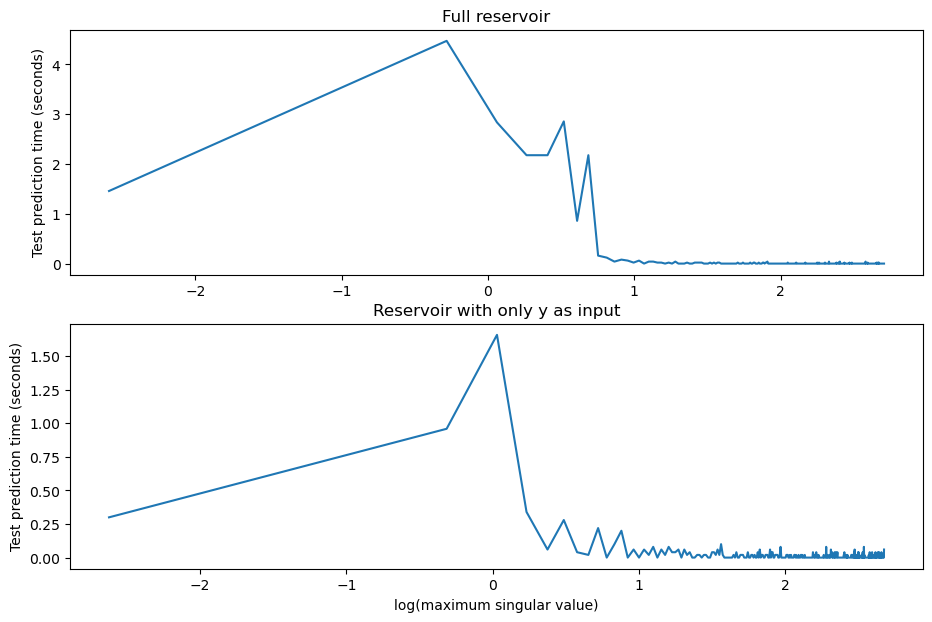

In [47]:
plt.figure(figsize=(11, 7))

plt.subplot(2,1,1)
plt.plot(np.log(max_sing_val), test_losses[1])
plt.title("Full reservoir")
plt.ylabel('Test prediction time (seconds)')

plt.subplot(2,1,2)
plt.plot(np.log(max_sing_val_y), test_losses_y[1])
plt.title("Reservoir with only y as input")
plt.ylabel('Test prediction time (seconds)')
plt.xlabel('log(maximum singular value)')

plt.show()

## Problem 4)

We want to determine the lyapunov exponent \\
We simulate the system for two slightly different initial conditions and compute the lyapunov exponent by fitting an exponential function - we do this by plottting the log of the error between them and fitting a linear curve - slope is lyapunov exponent

http://www.chebfun.org/examples/ode-nonlin/LyapunovExponents.html

In [48]:
# Parameters
sigma = 10
r = 28
b = 8/3

dt = 0.02
t_max = 50
num_steps = int(t_max/dt)
print("Number of time steps", num_steps)

initial_conditions = [0.3, 0.7, 0.95]
eps = 1e-9
initial_conditions_eps = [0.3, 0.7, 0.95+eps]

def lorenz(t, state, sigma, b, r):
    x, y, z = state
    x_dot = -sigma*(x - y)
    y_dot = r*x - y - x*z
    z_dot = -b*z + x*y
    return x_dot, y_dot, z_dot

# Integrate the Lorenz equations.
sol_fun_1 = solve_ivp(lorenz, (0, t_max), initial_conditions, args=(sigma, b, r),
                 dense_output=True)
# Interpolate solution onto the time grid, t.
t_eval = np.linspace(0, t_max, num_steps)
x, y, z = sol_fun_1.sol(t_eval)

data_sol_1 = np.array([x, y, z])

# Integrate the Lorenz equations.
sol_fun_eps = solve_ivp(lorenz, (0, t_max), initial_conditions_eps, args=(sigma, b, r),
                 dense_output=True)
# Interpolate solution onto the time grid, t.
t_eval = np.linspace(0, t_max, num_steps)
x, y, z = sol_fun_eps.sol(t_eval)

data_sol_eps = np.array([x, y, z])

Number of time steps 2500


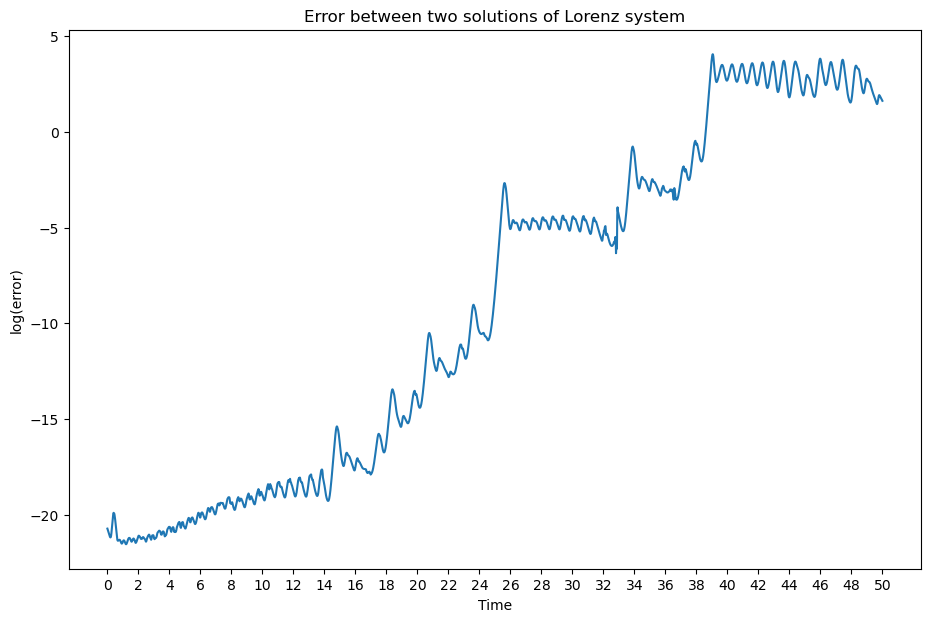

In [49]:
# Plot the two error between the two solutions
err = np.sqrt(np.sum((data_sol_1 - data_sol_eps)**2, axis=0))

fig = plt.figure(figsize=(11, 7))

plt.plot(t_eval, np.log(err))
plt.xlabel('Time')
plt.ylabel('log(error)')
plt.xticks(np.arange(0, t_max+1, 2))
plt.title("Error between two solutions of Lorenz system")

plt.show()

We fit the slope in time interval [17, 24]

Start time: 17.006802721088437
End time: 24.009603841536617
Slope: 0.953845986872762


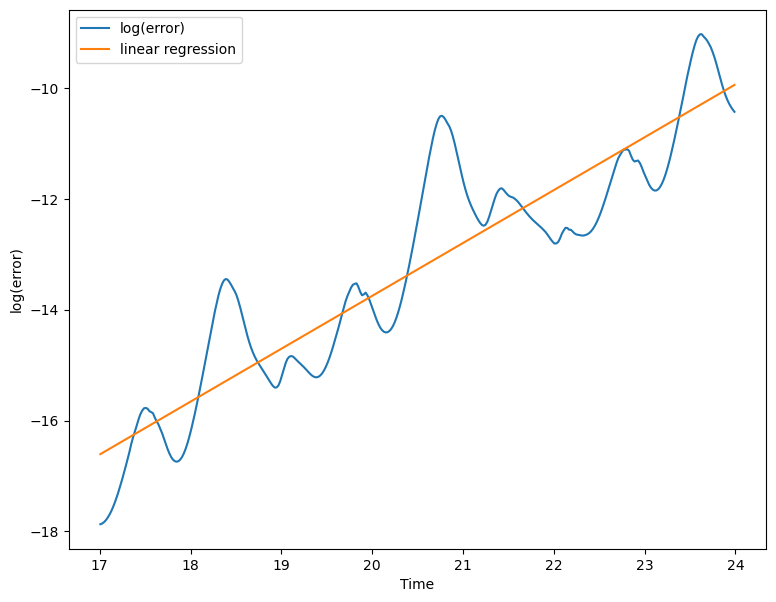

In [50]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

t_0 = 17
t_final = 24
t_0_idx = int(t_0/dt)
t_final_idx = int(t_final/dt)
print("Start time:", t_eval[t_0_idx])
print("End time:", t_eval[t_final_idx])

reg_time = t_eval[t_0_idx:t_final_idx]
log_err = np.log(err[t_0_idx:t_final_idx])

model.fit(reg_time.reshape(-1,1), log_err.reshape(-1,1)) # reshape to make it work

lyapunov_exp = model.coef_[0][0]
print("Slope:", lyapunov_exp)

# plot the regression
fig = plt.figure(figsize=(9, 7))
plt.plot(reg_time, log_err, label="log(error)")
plt.plot(reg_time, model.predict(reg_time.reshape(-1,1)), label="linear regression")
plt.xlabel('Time')
plt.ylabel('log(error)')
plt.xticks(np.arange(t_0, t_final+1, 1))
plt.legend()

plt.show()

Plot predicted error against lyapunov times - will examine only for full reservoir at best variance

In [51]:
# Define the network
N_in = 3 # Number of input neurons
N_out = 3 # Number of output neurons
N_res = 500 # Number of reservoir neurons

w_res_best = w_res_var[np.argmax(test_losses[1])]

np.random.seed(42) 
W_in = np.random.normal(0, np.sqrt(0.002), (N_res, N_in))
# W_res = np.random.normal(0, np.sqrt(2/N_res), (N_res, N_res))
W_res = np.random.normal(0, np.sqrt(w_res_best), (N_res, N_res))

# Train the network

num_steps_train = train_data.shape[1] # Number of training steps
R = np.zeros((N_res, num_steps_train)) # Reservoir states, initialized to 0

for t in range(num_steps_train-1):
    X = train_data[:,t]
    r = R[:,t]
    
    R[:,t+1] = np.tanh(W_res @ r + W_in @ X)
    
I = np.eye(N_res) # Identity matrix
k=0.01   # Ridge regression parameter

M1 = train_data @ R.T
M2 = R @ R.T + k*I
W_out = M1 @ np.linalg.inv(M2)

O_train = W_out @ R # Output of the network

In [52]:
# Predict the values in test data
O_test = np.zeros((N_out, test_data.shape[1])) # Output states, initialized to 0

# Get the last state from training data
r = R[:, -1]
for t in range(test_data.shape[1]-1):
    O = W_out @ r # first state comes from training
    
    r = np.tanh(W_res @ r + W_in @ O)
    O_test[:,t] = O

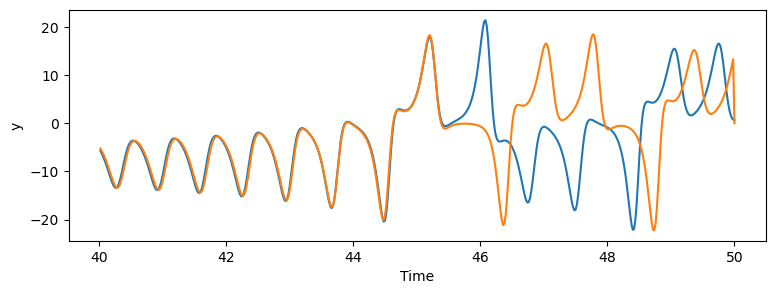

In [53]:
plt.figure(figsize=(9, 3))
plt.plot(test_time, test_data[1], label='Numerical')
plt.plot(test_time, O_test[1], label='Reservoir')
plt.xlabel('Time')
plt.ylabel('y')

plt.show()

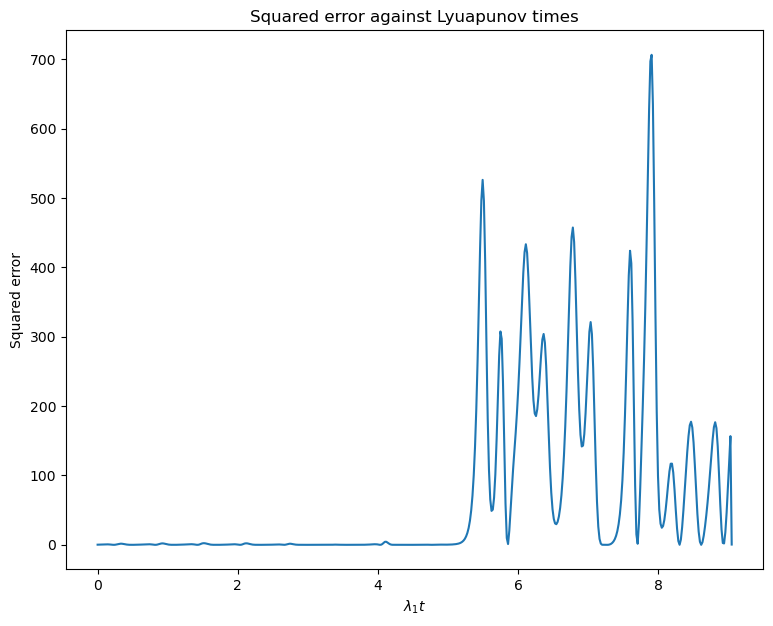

In [54]:
error = abs(O_test[1] - test_data[1])
squared_error = (O_test[1] - test_data[1])**2

# make the test time go from 0 
test_time_plot = np.linspace(0, max(test_time)-min(test_time), len(test_time))

lyapunov_exp_lit = 0.906

plt.figure(figsize=(9, 7))
plt.plot(test_time_plot*lyapunov_exp_lit, squared_error)
plt.xlabel(r"$\lambda_1 t$")
plt.ylabel('Squared error')
plt.title("Squared error against Lyuapunov times")

plt.show()